In [1]:
# Loading the required packages
import numpy as np
import pyspark
import pandas as pd
import boto3
from sagemaker import get_execution_role
from os import listdir
from os.path import isfile, join
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
# Initialize the spark environment
conf = pyspark.SparkConf().setAppName('vs4vx').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)

In [3]:
# Read into spark dataframe from csv in s3
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'vs4vx/forestfires.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
df = sqlc.createDataFrame(pd.read_csv(data_location))

In [4]:
# Convert to parquet
parquetPath = '/home/ec2-user/SageMaker/Open-Data-Lab/education/Spark19SpDS6003-001/vs4vx/parquet'
df.write.parquet(parquetPath)

In [5]:
# Write parquet to s3
# prep list of files to transfer
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

s3 = boto3.resource('s3')
for f in files:
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "vs4vx/pqt/"+f)

In [6]:
# Read parquet to spark dataframe
data = sqlc.read.parquet(parquetPath)

In [7]:
display(data)

DataFrame[X: bigint, Y: bigint, month: string, day: string, FFMC: double, DMC: double, DC: double, ISI: double, temp: double, RH: bigint, wind: double, rain: double, area: double]

In [8]:
data.printSchema()

root
 |-- X: long (nullable = true)
 |-- Y: long (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- FFMC: double (nullable = true)
 |-- DMC: double (nullable = true)
 |-- DC: double (nullable = true)
 |-- ISI: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- RH: long (nullable = true)
 |-- wind: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- area: double (nullable = true)



In [9]:
data.take(5)

[Row(X=7, Y=5, month='mar', day='fri', FFMC=86.2, DMC=26.2, DC=94.3, ISI=5.1, temp=8.2, RH=51, wind=6.7, rain=0.0, area=0.0),
 Row(X=7, Y=4, month='oct', day='tue', FFMC=90.6, DMC=35.4, DC=669.1, ISI=6.7, temp=18.0, RH=33, wind=0.9, rain=0.0, area=0.0),
 Row(X=7, Y=4, month='oct', day='sat', FFMC=90.6, DMC=43.7, DC=686.9, ISI=6.7, temp=14.6, RH=33, wind=1.3, rain=0.0, area=0.0),
 Row(X=8, Y=6, month='mar', day='fri', FFMC=91.7, DMC=33.3, DC=77.5, ISI=9.0, temp=8.3, RH=97, wind=4.0, rain=0.2, area=0.0),
 Row(X=8, Y=6, month='mar', day='sun', FFMC=89.3, DMC=51.3, DC=102.2, ISI=9.6, temp=11.4, RH=99, wind=1.8, rain=0.0, area=0.0)]

In [10]:
data = data.select("X","Y", "FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain", "area")

In [11]:
# create train/test sets
seed = 42
(testDF, trainingDF) = data.randomSplit((0.20, 0.80), seed=seed)
print('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 413, test set N = 104


In [12]:
# make a user defined function (udf)
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

# vectorize the data frames
trainingDF = trainingDF.selectExpr("area", "oneElementVec(X) as X", "oneElementVec(Y) as Y", "oneElementVec(FFMC) as FFMC", "oneElementVec(DMC) as DMC", "oneElementVec(DC) as DC", "oneElementVec(ISI) as ISI", "oneElementVec(temp) as temp", "oneElementVec(RH) as RH", "oneElementVec(wind) as wind", "oneElementVec(rain) as rain")
testDF = testDF.selectExpr("area", "oneElementVec(X) as X", "oneElementVec(Y) as Y", "oneElementVec(FFMC) as FFMC", "oneElementVec(DMC) as DMC", "oneElementVec(DC) as DC", "oneElementVec(ISI) as ISI", "oneElementVec(temp) as temp", "oneElementVec(RH) as RH", "oneElementVec(wind) as wind", "oneElementVec(rain) as rain")

In [13]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'], outputCol = 'features')
trainingDF = vectorAssembler.transform(trainingDF)
trainingDF = trainingDF.select(['features', 'area'])
testDF = vectorAssembler.transform(testDF)
testDF = testDF.select(['features', 'area'])

In [14]:
trainingDF = trainingDF.withColumnRenamed("area", "label")
testDF = testDF.withColumnRenamed("area", "label")

In [15]:
# Build the model
lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [16]:
type(lrModel)

pyspark.ml.regression.LinearRegressionModel

In [17]:
# Make predictions
predictionsAndLabelsDF = lrModel.transform(testDF)

In [18]:
# Model Evaluation
eval = RegressionEvaluator()

In [19]:
eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)

22.808595864541225

In [20]:
y = np.array(testDF.select('label').collect())
x = np.array(predictionsAndLabelsDF.select('label').collect())

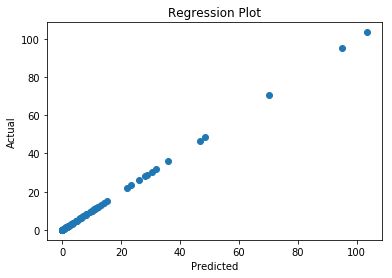

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(x, y)
plt.title('Regression Plot')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()